In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

%matplotlib inline
from keras.utils import np_utils

train = pd.read_csv('../train.csv', sep=',', header=0)
test = pd.read_csv('../test.csv', sep=',', header=0)

train = train.fillna(" ")
test = test.fillna(" ")
print(train.shape)

import nltk
nltk.download('stopwords')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss

train.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


(404290, 6)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [2]:
nltk.download('averaged_perceptron_tagger')
import difflib
from collections import Counter

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def noun_extracter(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    return np.array([w for w, t in nltk.pos_tag(tokens) if t[:1] in ['N']])
    
def word_match_share(q1,q2):
    q1 = q1.split()
    q2 = q2.split()
    if(len(q1) == 0 or len(q2) == 0):
        return 0
    else:
        both = set(q1).intersection(set(q2))
        return len(both) * 2 / (len(q1) + len(q2))
    
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])

class LemmaTokenizer(object):
    def __init__(self):
        self.snbstem = SnowballStemmer('english')
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.remove('but')
        self.stop_words.remove('not') # left outer join would be nice...
        self.tokenizer = RegexpTokenizer('[a-z]\w+')
    def lmtokenize(self,doc):
        temp = [self.snbstem.stem(t) for t in self.tokenizer.tokenize(doc.lower()) if t not in self.stop_words]
        return " ".join(temp)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
def getFeatures(df):

    questions1 = df["question1"].values
    questions2 = df["question2"].values

    stopWRe_q1 = removePunktAndStopwords(questions1)
    stopWRe_q2 = removePunktAndStopwords(questions2)

    df['question1_nouns'] = pd.Series(Parallel(n_jobs=7)(delayed(noun_extracter)(x) for x in questions1))
    df['question2_nouns'] = pd.Series(Parallel(n_jobs=7)(delayed(noun_extracter)(x) for x in questions2))
    df['z_len1'] = df.question1.map(lambda x: len(str(x)))
    df['z_len2'] = df.question2.map(lambda x: len(str(x)))
    df['z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df['z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df['z_noun_match'] = df.apply(lambda r: 
                                        sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)
    df['z_match_ratio'] = pd.Series(Parallel(n_jobs=7)
                                       (delayed(diff_ratios)(x,y) for x,y in zip(stopWRe_q1,stopWRe_q2)))
    df['z_word_match'] = pd.Series(Parallel(n_jobs=7)
                                      (delayed(word_match_share)(x,y) for x,y in zip(questions1,questions2)))
    

train = getFeatures(train)
test = getFeatures(test)
col = [c for c in train.columns if c[:1]=='z']

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


OSError: [Errno 12] Cannot allocate memory

In [5]:
test.columns

Index(['test_id', 'question1', 'question2', 'question1_nouns',
       'question2_nouns', 'z_len1', 'z_len2', 'z_word_len1', 'z_word_len2',
       'z_noun_match'],
      dtype='object')

In [ ]:
preprocessor = LemmaTokenizer()
stemmed_q1 = Parallel(n_jobs=6)(delayed(preprocessor.lmtokenize)(sentence) for sentence in stopWRe_q1)
stemmed_q2 = Parallel(n_jobs=6)(delayed(preprocessor.lmtokenize)(sentence) for sentence in stopWRe_q2)

length1 = np.array([len(x.split()) for x in stopWRe_q1])
length2 = np.array([len(x.split()) for x in stopWRe_q2])

vect = CountVectorizer(max_df=0.6,min_df=4)
vect.fit(np.concatenate((stemmed_q1,stemmed_q2)))
bow_q1 = vect.transform(stemmed_q1)
bow_q2 = vect.transform(stemmed_q2)
vocab_q1 = np.asarray(["q1_" + x for x in vect.get_feature_names()])
vocab_q2 = np.asarray(["q2_" + x for x in vect.get_feature_names()])

In [5]:
features = sp.sparse.hstack([bow_q1,bow_q2,train[col].values])
labels = train["is_duplicate"]
feature_names = np.concatenate([vocab_q1,vocab_q2,np.array(col)])
print(features.shape)
print("done preprocessing")

(404290, 46186)
done preprocessing


In [66]:
# scaling of neg and pos examples (ratio as in test set) EVEN reduces logloss on training data ~6 percentpoints
pos_train = train[train['is_duplicate'] == 1]
neg_train = train[train['is_duplicate'] == 0]
p = 0.165 # kaggle test set ratio 
p = 0.1
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1

while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train2 = pd.concat([pos_train, neg_train])
print(train2.shape)
print(train.shape)

(1875263, 15)
(404290, 15)


In [67]:
#easy to use XGB with scikit api
X_train, X_test, y_train, y_test = train_test_split(train2[col].values, train2["is_duplicate"], test_size=0.2, random_state=42)

model = xgb.XGBClassifier(max_depth=7,n_estimators=400)
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:,1]

print("log loss on held out test set: %.3f" %log_loss(y_test,preds))

log loss on held out test set: 0.218


In [ ]:
preds = model.predict_proba(test[col].values)
test["is_duplicate"] = pd.Series(preds[:,1],index=test.index)
header = ["test_id", "is_duplicate"]
test.to_csv('../submissions/predictions.csv', columns = header,index=False)

(156098,)


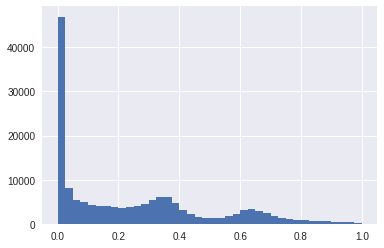

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0.00451295  0.00449331  0.0044356   0.00439808  0.00434496  0.00431287
  0.00420541  0.00405402  0.00396624  0.00356043  0.00292734  0.00276675
  0.00273159  0.00269549  0.00264607  0.00251772  0.00242891  0.00225601
  0.0018938   0.00187162  0.00164326  0.00138574  0.00134483  0.0012588
  0.00113124  0.00092715  0.00081554  0.00068751  0.00058897  0.00024769]


array([[ 'If Belgium split in two, would Wallonia and Flanders become independent States or become part of France and the Netherlands respectively?',
        'If Belgium was ever partitioned, would Flanders join the Netherlands and Wallonia France, or would they remain independent republics?'],
       ['How does Quora quickly mark questions as needing improvement?',
        'Why does Quora mark my questions as needing improvement/clarification before I have time to give it details? Literally within seconds…'],
       ['What are inspirational movies to watch?',
        'Which are best inspirational movies?'],
       ['What is the meaning of imperialism?',
        'What is the definition of imperialism?'],
       ['What is a Walmart Rollback? What are they for?',
        'What are the customer service hours at Walmart?'],
       [ 'I broke up with my girlfriend a week before. I need her back, what should I do?',
        'I broke up with my girlfriend and I want her back. What should I do

In [52]:


diff = np.abs(y_test-preds) # needs y_test = y_test.values

print(diff.shape)
plt.hist(diff,40); plt.show()
idx = np.argsort(diff)


nums= 30
print(y_test[idx[-nums:]])
print(preds[idx[-nums:]])
train2.iloc[idx[-nums:],3:5].values

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0.00251772  0.00242891  0.00225601  0.0018938   0.00187162  0.00164326
  0.00138574  0.00134483  0.0012588   0.00113124  0.00092715  0.00081554
  0.00068751  0.00058897  0.00024769]


In [20]:
# xgb api with additional methods and params 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
# classification

Dtrain = xgb.DMatrix(X_train,y_train,feature_names=feature_names)
Dtest = xgb.DMatrix(X_test,y_test,feature_names=feature_names)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1632

bst = xgb.train(params,Dtrain,500)

In [21]:
preds = bst.predict(Dtest)
print("log loss on held out test set: %.3f" %log_loss(y_test,preds))

log loss on held out test set: 0.582


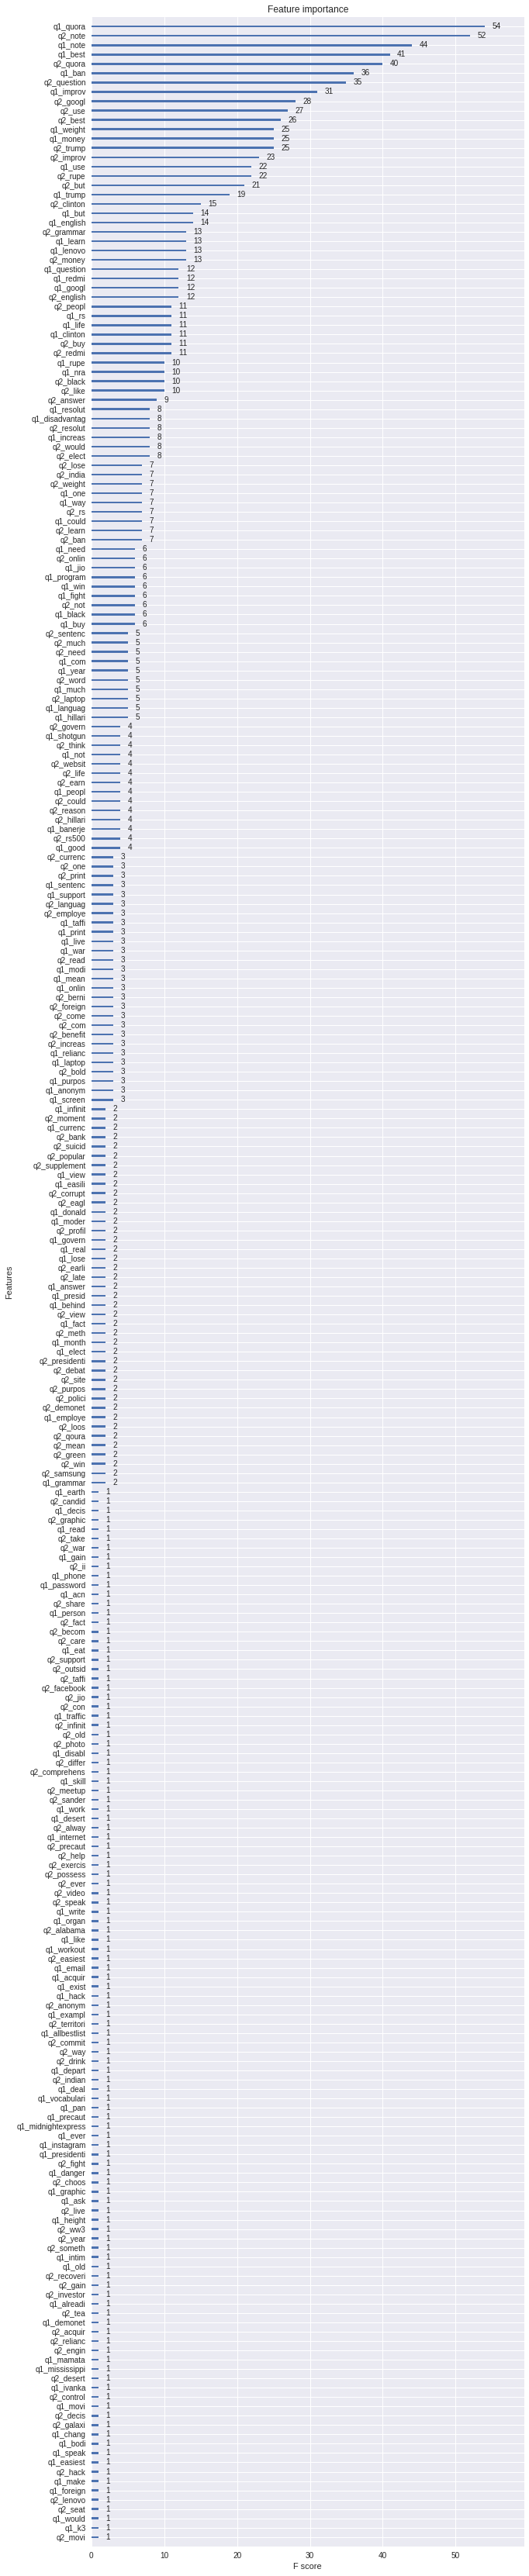

In [16]:
plt.rcParams['figure.figsize'] = (10.0, 60.0)
xgb.plot_importance(bst); plt.show()